In [1]:
from io import StringIO

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lsst.rsp import get_tap_service
from lsst.skymap import TractInfo

In [2]:
def query_and_table(service, query):
    return service.search(query).to_table().to_pandas()
        

def sregion_to_vertices(sregion: str, closed=True):
    """Convert the s_region from the ObsCore table into two
    arrays containing the x and y vertices, in order to plot
    boxes using matplotlib.
    From Rubin DP0.2 Tutorial notebooks by the Community Science Team.
    """
    temp = sregion.split(' ')
    xvertices = []
    yvertices = []
    ix = 2
    iy = 3
    for c in range(4):
        xvertices.append(float(temp[ix]))
        yvertices.append(float(temp[iy]))
        ix += 2
        iy += 2
    if closed:
        xvertices.append(xvertices[0])
        yvertices.append(yvertices[0])
    return np.array(xvertices), np.array(yvertices)

In [3]:
service = get_tap_service("tap")

# DP1 and Swift

According [Swift GCN page](https://gcn.gsfc.nasa.gov/swift_grbs.html) the GRBs lovalized over the timespan in which DP1 data were collected (24/10/24 to 24/12/11) are:

In [4]:
grbs_str = """
instrument,id,date,time,ra,dec,uncertainty
swift-xrt, 1262165, 24-10-25, 01:36:50.57, 333.6544, +83.5759, 1.9
swift-xrt, 1262764, 24-10-26, 22:42:32.00, 293.3991, +57.9853, 1.9
swift-xrt, 1263718, 24-10-30, 05:48:03.12, 343.1400, +80.4482, 4.7
swift-xrt, 1263840, 24-10-30, 18:34:20.91, 50.7926, +34.4469, 1.9
swift-bat, 1264304, 24-11-01, 05:41:45.76, 204.333, +28.264, 180.00
swift-xrt, 1267501, 24-11-13, 07:48:13.79, 16.5650, -22.6711, 4.6
swift-xrt, 1267921, 24-11-15, 13:18:25.04, 86.7701, -0.6746, 1.9
swift-xrt, 1270788, 24-11-27, 21:43:16.23, 327.8842, -56.6648, 5.1
swift-xrt, 1270999, 24-11-28, 16:14:34.24, 273.7248, +33.4390, 5.5
swift-xrt, 1273071, 24-12-09, 05:35:44.07, 155.3970, +6.3282, 1.9
swift-xrt, 1273106, 24-12-09, 10:59:46.43, 190.1137, -2.8901, 5.0
"""

grbs_df = pd.read_csv(StringIO(grbs_str))

In [5]:
grbs_df

,instrument,id,date,time,ra,dec,uncertainty
0,swift-xrt,1262165,24-10-25,01:36:50.57,333.6544,83.5759,1.9
1,swift-xrt,1262764,24-10-26,22:42:32.00,293.3991,57.9853,1.9
2,swift-xrt,1263718,24-10-30,05:48:03.12,343.1400,80.4482,4.7
3,swift-xrt,1263840,24-10-30,18:34:20.91,50.7926,34.4469,1.9
4,swift-bat,1264304,24-11-01,05:41:45.76,204.3330,28.2640,180.0
5,swift-xrt,1267501,24-11-13,07:48:13.79,16.5650,-22.6711,4.6
6,swift-xrt,1267921,24-11-15,13:18:25.04,86.7701,-0.6746,1.9
7,swift-xrt,1270788,24-11-27,21:43:16.23,327.8842,-56.6648,5.1
8,swift-xrt,1270999,24-11-28,16:14:34.24,273.7248,33.4390,5.5
9,swift-xrt,1273071,24-12-09,05:35:44.07,155.3970,6.3282,1.9


We build a structures with infos on the skymap tracts covered by the DP1.

In [6]:
field_tracts = {
    "ECDFS": [5062, 5063, 5064, 4848, 4849],
    "Seagull": [7850, 7849, 7610, 7611],
    "Rubin_SV_38_7": [10464, 10221, 10222, 10704, 10705, 10463],
    "EDFS_comcam": [2393, 2234, 2235, 2394],
    "Rubin_SV_095_-25": [5305, 5306, 5525, 5526],
    "47_Tuc": [531, 532, 453, 454],
    "Fornax_dSph": [4016, 4217, 4218, 4017],
}
field_coords = {
    "ECDFS": (53.160, -28.100),
    "Seagull": (106.300, -10.510),
    "Rubin_SV_38_7": (37.980, 7.015),
    "EDFS_comcam": (59.150, -48.730),
    "Rubin_SV_095_-25": (95.040, -25.000),
    "47_Tuc": (6.128, -72.090),
    "Fornax_dSph": (40.080, -34.450),
}

In [7]:
query = """
SELECT column_name, datatype, description, unit
FROM tap_schema.columns
WHERE table_name = 'dp1.CoaddPatches'
"""

query_and_table(service, query)

,column_name,datatype,description,unit
0,lsst_patch,long,"ID number of the second level, 'patch', within...",
1,lsst_tract,long,"ID number of the top level, 'tract', within th...",
2,s_dec,double,Central Spatial Position in ICRS; Declination,deg
3,s_ra,double,Central Spatial Position in ICRS; Right ascension,deg
4,s_region,char,Sky region covered by the coadd (expressed in ...,


In [8]:
query = """
SELECT *
FROM dp1.CoaddPatches
"""

patches_df = query_and_table(service, query)

We plot the LSST starfields and Swift detections.

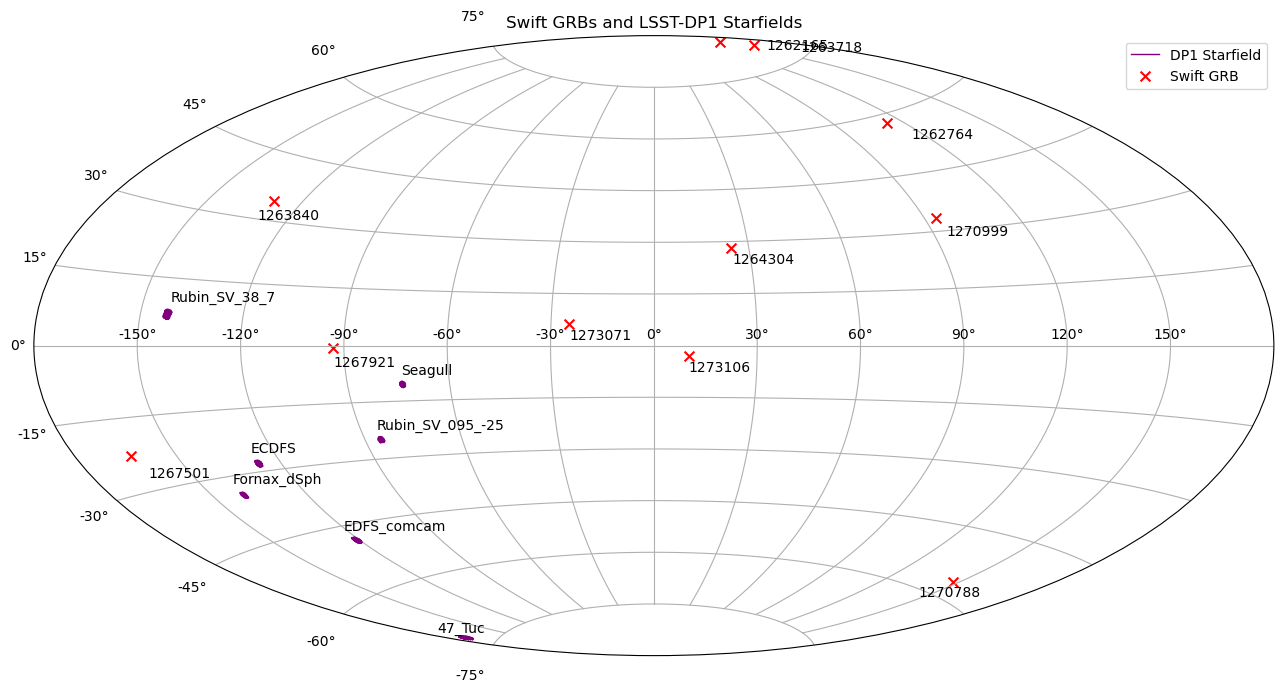

In [9]:
fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111, projection='aitoff')
labelled = False
for i, row in patches_df.iterrows():
    xvals, yvals = sregion_to_vertices(row['s_region'])
    xvals = np.deg2rad(xvals - 180)
    yvals = np.deg2rad(yvals)
    ax.plot(xvals, yvals, lw=1, color='purple', label="DP1 Starfield" if not labelled else None)
    labelled = True
for label, ra_dec in field_coords.items():
    ra, dec = ra_dec
    ra = np.deg2rad(ra - 180)
    dec = np.deg2rad(dec)
    ax.text(ra, dec + 0.05, label)
labelled = False
for i, row in grbs_df.iterrows():
    ra = np.deg2rad(row["ra"] - 180)
    dec = np.deg2rad(row["dec"])
    label = row["id"]
    plt.scatter(ra, dec, marker = "x", color="red", s=50, label="Swift GRB" if not labelled else None)
    ax.text(ra, dec - 0.08, f"{label}")
    labelled = True
plt.grid()
plt.title("Swift GRBs and LSST-DP1 Starfields")
plt.legend()
plt.show()

# How probable it is that we got a GRB in there?

Is it worthy to try and go beyond Swift? Maybe investigating detections from EP or SVOM, adding their detections to our dataset?

Napkin math assuming one GRB per day. How likely it is that we got one GRB falling in the DP1 starfields over the 48 nights of observation?

In [12]:
from scipy.stats import poisson

grb_rate = 1  # per day per 4pi sterad
coverage_dp1 = 15  # sq.deg
nnights = 48
expected_dp1 = 0.5 * nnights * grb_rate * (coverage_dp1 / 42_000) # 0.5 because we observe only at night
p = 100 * (1 - poisson(mu=expected_dp1).pmf(0))

In [13]:
print(f"Probability of getting at least one GRB over 48 nights, given a rate of 1 event per day is: {p:.2f}%")

Probability of getting at least one GRB over 48 nights, given a rate of 1 event per day is: 0.85%


A small montecarlo confirms this estimate:

In [14]:
from scipy.stats import binom

N = 1_000_000
isin = binom(p = 0.5 * 1 * (15 / 42_000), n=48).rvs(N)
empirical = 100 * np.sum(isin > 0) / N

In [15]:
print(f"Fraction of nights with one or more detected events (out of a simulation sample of N={N}): {empirical:.2f}%")

Fraction of nights with one or more detected events (out of a simulation sample of N=1000000): 0.86%
